In [14]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Función para generar espectrograma a partir de un archivo de audio
def generar_espectrograma(audio_path, tamaño=(128, 128)):
    # Cargar el archivo de audio
    y, sr = librosa.load(audio_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Calcular el espectrograma
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Mostrar el espectrograma
    plt.figure(figsize=(5, 2))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('imagen_sin_fondo.png', transparent=True, bbox_inches='tight', pad_inches=0)
    plt.show()

    # Convertir a imagen (en escala de grises)
    espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar
    espectrograma_imagen = cv2.resize(espectrograma_imagen, tamaño)  # Redimensionar

    return espectrograma_imagen


In [8]:
from tensorflow.keras.models import load_model

# Cargar el modelo previamente entrenado
# Suponiendo que ya has guardado tu modelo con model.save() como 'modelo_voces.h5'
model = load_model('/content/drive/MyDrive/Proyecto SIC/modelo_RNN_CNN_DetectVoice_00.h5')

def predecir_voces(audio_path, tamaño=(128, 128)):
    # Paso 1: Generar el espectrograma desde el archivo de audio
    espectrograma_imagen = generar_espectrograma(audio_path, tamaño)

    # Paso 2: Normalizar y agregar la dimensión de los canales (para que sea compatible con el modelo)
    espectrograma_imagen = espectrograma_imagen / 255.0  # Normalizar
    espectrograma_imagen = espectrograma_imagen.reshape(1, tamaño[0], tamaño[1], 1)  # (1, 128, 128, 1)

    # Paso 3: Hacer la predicción
    prediccion = model.predict(espectrograma_imagen)

    # Convertir la predicción en una clase
    clase_predicha = np.argmax(prediccion, axis=1)[0]
    confianza = prediccion[0][clase_predicha] * 100  # Confianza en porcentaje

    # Mostrar la predicción
    print(f"Predicción del modelo: Clase {clase_predicha} ({'IA' if clase_predicha == 0 else 'Voz Real'})")
    print(f"Confianza: {confianza:.2f}%")

    return clase_predicha, confianza

#vamos a limpiar las metricas


In [3]:
#ingresamos al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


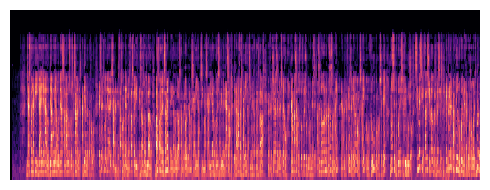

<ipython-input-7-b66c38478f4b>:25: RuntimeWarning: divide by zero encountered in divide
  espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar
<ipython-input-7-b66c38478f4b>:25: RuntimeWarning: invalid value encountered in divide
  espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar
<ipython-input-7-b66c38478f4b>:25: RuntimeWarning: invalid value encountered in cast
  espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicción del modelo: Clase 0 (IA)
Confianza: 100.00%


In [9]:
# Probar con un archivo de audio
audio_path = '/content/Ibai_real.wav'  # Ruta al archivo de audio
clase, confianza = predecir_voces(audio_path)


In [15]:
#vamos a probrar Juntar el modelo 02 de RNN+ CNN y el de solo CNN
from tensorflow.keras.models import load_model
import numpy as np

# Cargar los modelos
modelo_1 = load_model('/content/drive/MyDrive/Proyecto SIC/modelo_RNN_CNN_DetectVoice_00.h5')
modelo_2 = load_model('/content/drive/MyDrive/Proyecto SIC/modelo_CNN_DetectVoice_00.h5')

# Pesos para cada modelo (50% cada uno)
peso_modelo_1 = 0.3
peso_modelo_2 = 0.7

In [25]:
def predecir_ensemble(espectrograma, modelos, pesos):
    # Validar que el número de modelos coincida con los pesos
    if len(modelos) != len(pesos):
        raise ValueError("El número de modelos y pesos debe coincidir.")

    # Cargar y procesar la imagen
    img = cv2.imread('imagen_sin_fondo.png', cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se encontró la imagen en la ruta: {ruta_imagen}")

    # Redimensionar la imagen al tamaño esperado por los modelos
    img = cv2.resize(img, (128, 128))  # Ajustar a (128, 128)
    img = img / 255.0  # Normalizar la imagen
    img = np.expand_dims(img, axis=(0, -1))  # Agregar dimensiones para el batch y el canal

    # Inicializar la suma ponderada de las predicciones
    suma_predicciones = np.zeros(modelos[0].output_shape[1])  # Tamaño según salida del modelo

    # Realizar predicciones y combinar con pesos
    for modelo, peso in zip(modelos, pesos):
        prediccion = modelo.predict(img)[0]  # Predicción del modelo actual
        suma_predicciones += prediccion * peso

    # Determinar la clase final y la confianza
    clase_predicha = np.argmax(suma_predicciones)
    confianza = suma_predicciones[clase_predicha] * 100

    return clase_predicha, confianza

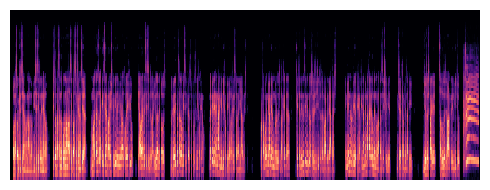

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Clase predicha: 0 (IA)
Confianza: 85.29%


<ipython-input-14-4d312e3a8a2d>:26: RuntimeWarning: divide by zero encountered in divide
  espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar
<ipython-input-14-4d312e3a8a2d>:26: RuntimeWarning: invalid value encountered in divide
  espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar
<ipython-input-14-4d312e3a8a2d>:26: RuntimeWarning: invalid value encountered in cast
  espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar


In [30]:
# Lista de modelos y pesos
modelos = [modelo_1, modelo_2]
pesos = [peso_modelo_1, peso_modelo_2]

# Espectrograma de prueba
espectrograma_prueba = generar_espectrograma('/content/videoplayback.mp3.mp3')  # Asegúrate de preprocesar correctamente

# Predicción con el ensemble
clase_predicha, confianza = predecir_ensemble(espectrograma_prueba, modelos, pesos)

# Mostrar el resultado
print(f"Clase predicha: {clase_predicha} ({'IA' if clase_predicha == 0 else 'Voz Real'})")
print(f"Confianza: {confianza:.2f}%")


In [ ]:
#Vamos a Probar entrenarla de nuevo
def predecir_con_retroalimentacion(modelo, espectrograma, etiqueta_real=None, reentrenar=False, datos_retro=[]):
    # Preprocesar la imagen
    espectrograma = espectrograma / 255.0
    espectrograma = espectrograma.reshape(1, 128, 128, 1)  # Ajusta según el tamaño esperado

    # Hacer la predicción
    prediccion = modelo.predict(espectrograma)[0]
    clase_predicha = np.argmax(prediccion)
    confianza = prediccion[clase_predicha] * 100

    # Mostrar resultados
    print(f"Predicción: Clase {clase_predicha} ({'IA' if clase_predicha == 0 else 'Voz Real'})")
    print(f"Confianza: {confianza:.2f}%")

    if etiqueta_real is not None:
        if clase_predicha == etiqueta_real:
            print("¡Predicción correcta!")
        else:
            print("Predicción incorrecta.")
            if reentrenar:
                datos_retro.append((espectrograma, etiqueta_real))

    return datos_retro

In [ ]:
def reentrenar_modelo(modelo, datos_retro, epochs=5, batch_size=8):
    if not datos_retro:
        print("No hay nuevos datos para reentrenar.")
        return modelo

    # Separar características (X) y etiquetas (y)
    X_retro, y_retro = zip(*datos_retro)
    X_retro = np.vstack(X_retro)  # Convertir a array
    y_retro = np.array(y_retro)

    # Convertir etiquetas a one-hot
    from tensorflow.keras.utils import to_categorical
    y_retro = to_categorical(y_retro, num_classes=2)

    # Reentrenar el modelo
    modelo.fit(X_retro, y_retro, epochs=epochs, batch_size=batch_size, verbose=1)

    print("Modelo reentrenado con datos de retroalimentación.")
    return modelo


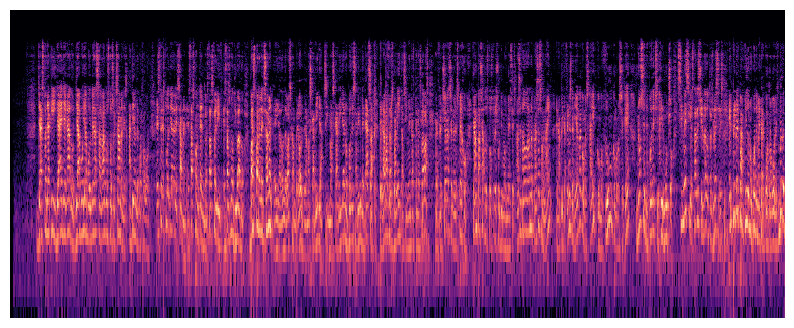

<ipython-input-19-cffc2ad9fcf5>:23: RuntimeWarning: divide by zero encountered in divide
  espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar
<ipython-input-19-cffc2ad9fcf5>:23: RuntimeWarning: invalid value encountered in divide
  espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar
<ipython-input-19-cffc2ad9fcf5>:23: RuntimeWarning: invalid value encountered in cast
  espectrograma_imagen = np.array(D * 255 / np.max(D), dtype=np.uint8)  # Normalizar


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Predicción: Clase 0 (IA)
Confianza: 100.00%
Predicción incorrecta.


In [ ]:
# Inicialización
modelo = load_model('/content/drive/MyDrive/Proyecto SIC/modelo_RNN_CNN_DetectVoice_02.h5')
datos_retroalimentacion = []

# Simulación de predicción con retroalimentación
espectrograma_prueba = generar_espectrograma('/content/Ibai_real.wav')  # Función que genera el espectrograma
etiqueta_real = 1  # Clase verdadera (1: Voz real, 0: IA)

# Realizar predicción y recibir retroalimentación
datos_retroalimentacion = predecir_con_retroalimentacion(
    modelo, espectrograma_prueba, etiqueta_real=etiqueta_real, reentrenar=True, datos_retro=datos_retroalimentacion
)

# Reentrenar el modelo si hay suficientes datos
if len(datos_retroalimentacion) > 10:  # Reentrenar después de acumular 10 muestras
    modelo = reentrenar_modelo(modelo, datos_retroalimentacion)
    datos_retroalimentacion = []  # Limpiar datos
